# Séries Temporais
---
Uma série temporal é uma coleção de dados indexados, listados ou estrurados em grafos que possuem uma ordem temporal intrínseca. Em geral, uma série temporal é uma sequência de amostras coletadas em intervalos regulares de tempo, sendo esta sequência definica como série-temporal discreta.

Neste notebook será investigada a utilização do Gráfico de Recorrência (RP, do inglês *Recurrence Plot*) como forma de representação de séries temporais, de modo que seja possível realizar a tarefa de classificação das mesmas utilizando Redes Neurais Artificiais Profundas (mais precisamente a arquitetura CNN, do inglês *Convolutional Neural Network*).

Uma vez que CNN's exigem uma imagem como entrada do modelo, a série temporal deve ser convertida em representação gráfica. Uma abordagem típica para esta tarefa é converter a série-temporal original em imagem através de seu Espectograma; porém, há uma perda considerável de informações nesta estratégia, pois em um Espectrograma importa onde um efeito aparece em contraste com CNNs, onde é assumido que um recurso é do mesmo tipo, não importa onde esteja na imagem. O uso de gráficos de recorrência como visualização da estrutura de recorrência de uma série temporal é, portanto, vantajoso. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
import time
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


## Gráficos de Recorrência
---
Recurrence plots are a visualization tool for (multivariate) time-series. They are based on exploring the characteristic recurrent behaviour of a time-series. Let  q(t)∈Rd  be a multi-variate time-series. It's recurrence plot is defined as

In [1]:
#modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

Como primeiro exemplo, vamos criar um RP de uma série-temporal discreta aleatória e outra série sinus. Claramente, a estrutura regular do Sinus fica visível, pois os padrões rrecorrentes da série são expostos.

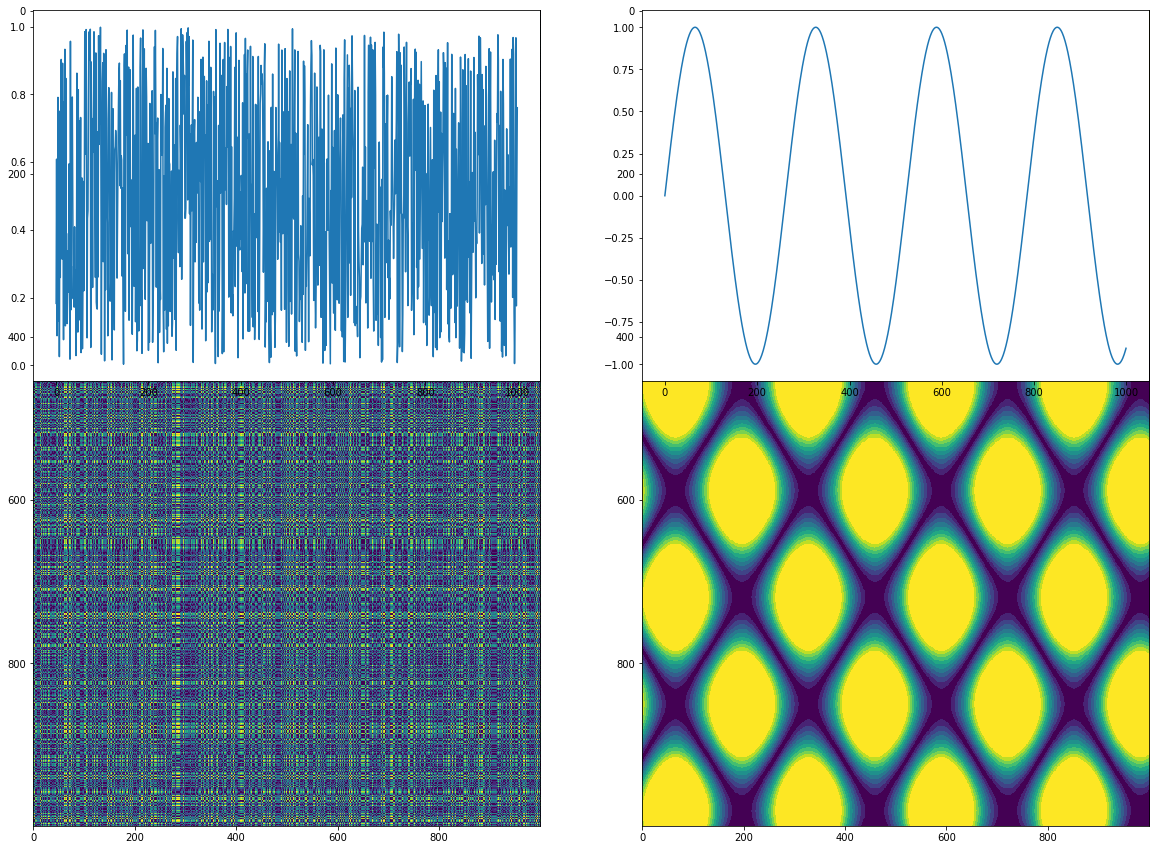

In [6]:
fig = plt.figure(figsize=(20,15))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

random_series = np.random.random(1000)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(recurrence_plot(random_series[:,None]), aspect="auto")
ax = fig.add_subplot(2, 2, 1)
plt.plot(list(range(0,1000)), random_series)

sinus_series = np.sin(np.linspace(0,24,1000))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(sinus_series[:,None]), aspect="auto")
ax = fig.add_subplot(2, 2, 2)
plt.plot(list(range(0,1000)), sinus_series)

In [10]:
!! pip install cmpy

['Collecting cmpy',
 '  Downloading https://files.pythonhosted.org/packages/58/11/29854680c85211fc1e813bc94dbedb32a9806dff94ae21577320d42df1d9/cmpy-0.2.tar.gz',
 'Building wheels for collected packages: cmpy',
 '  Building wheel for cmpy (setup.py): started',
 "  Building wheel for cmpy (setup.py): finished with status 'done'",
 '  Stored in directory: C:\\Users\\diego\\AppData\\Local\\pip\\Cache\\wheels\\41\\8e\\c3\\43befae7522ca9abba86f88ebc0ee3785b5b8c567ef557aa8e',
 'Successfully built cmpy',
 'Installing collected packages: cmpy',
 'Successfully installed cmpy-0.2']

In [35]:
# Ref.: http://node99.org/tutorials/ar/

def lorenz_generate(data_length):
    return generate(data_length, lorenz_odes, \
        np.array([-8.0, 8.0, 27.0]), np.array([10.0, 8/3.0, 28.0]))

#def lorenz_odes((x, y, z), (sigma, beta, rho)):
def lorenz_odes(*args):
    states = args[0]
    x = states[0]
    y = states[1]
    z = states[2]
    parameters = args[1]
    sigma = parameters[0]
    beta = parameters[1]
    rho = parameters[2]
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

def generate(data_length, odes, state, parameters):
    data = np.zeros([state.shape[0], data_length])

    for i in range(5000):
        state = rk4(odes, state, parameters)

    for i in range(data_length):
        state = rk4(odes, state, parameters)
        data[:, i] = state

    return data

def rk4(odes, state, parameters, dt=0.01):
    k1 = dt * odes(state, parameters)
    k2 = dt * odes(state + 0.5 * k1, parameters)
    k3 = dt * odes(state + 0.5 * k2, parameters)
    k4 = dt * odes(state + k3, parameters)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6






# #def rossler_odes((x, y, z), (a, b, c)):
# def rossler_odes(*states, **parameters):
#     x = states[0]
#     y = states[1]
#     z = states[2]
#     a = parameters[0]
#     b = parameters[1]
#     c = parameters[2]
#     return np.array([-y - z, x + a * y, b + z * (x - c)])


# def rossler_generate(data_length):
#     return generate(data_length, rossler_odes, \
#         np.array([10.0, 0.0, 0.0]), np.array([0.15, 0.2, 10.0]))

data = lorenz_generate(2**13)

8.0
7.92
7.89992
7.802485096533333
7.803176288945628
7.690394560745676
7.681881171298678
7.561755588209
7.562600181320734
7.437667295461523
7.437297682984532
7.312046213906822
7.31300453681639
7.1902965723168615
7.195451448476815
7.077173387950952
7.078192432160237
6.9673741969747525
6.9761278599716725
6.8728469064370845
6.873878018875749
6.781189488022288
6.792169989158235
6.708971610015087
6.709976912661288
6.639239085434359
6.651495468615482
6.59140619870943
6.592359391736833
6.545728685830811
6.5586195179237246
6.523261315732764
6.524146129775571
6.502663809864545
6.515769584464576
6.505833404069121
6.50664138557118
6.510624632260538
6.5236815457999455
6.539262249340665
6.53999064169926
6.569305046678176
6.582156018401978
6.622983777151014
6.623633775268603
6.677878533208299
6.690437325901385
6.756032772421158
6.756608198308004
6.835237360715588
6.847462265992625
6.937235582764344
6.937741935979084
7.040138582471518
7.052012881808908
7.165321276215823
7.1657650854423265
7.291280233

-16.285221227992857
-16.22765723067731
-15.73604720763303
-15.733805161928991
-15.184650878959838
-15.134132387205161
-14.543855089705824
-14.540953784312777
-13.900551471364102
-13.860140328355739
-13.190578133611645
-13.187114388386714
-12.477751846869582
-12.449719872187869
-11.724725996866747
-11.720865695798341
-10.968478778945945
-10.954013954318647
-10.199876429657445
-10.195832431183232
-9.427709805138026
-9.426796511815716
-8.66995506388117
-8.665954709130352
-7.908367788510063
-7.919862767151573
-7.18473985336105
-7.1809903597201155
-6.457122834289459
-6.478998437750505
-5.786260349977915
-5.782920825511156
-5.111380804906348
-5.141069202724782
-4.506517849004877
-4.503683921782618
-3.897733602698745
-3.9324917129121975
-3.3666431087692077
-3.364345678735507
-2.83182885588902
-2.8690545864721773
-2.3773298354152166
-2.3755452851429126
-1.9193750376702559
-1.9568321231669168
-1.5402009552574054
-1.53886780681772
-1.1578768663578383
-1.1938158890657913
-0.8497012373512257
-0.84

1.1610434712673596
1.5494501878826066
1.5505355424286191
1.8920769135863358
1.8480049692249956
2.1463380197068767
2.1470337011162353
2.404170140045087
2.3665729365494466
2.5874712439720837
2.587916578923769
2.773866886311109
2.742783448809003
2.8991597757151
2.899460778468164
3.0271416035178773
3.0022032745750993
3.106381881316961
3.1066125978988937
3.1879706053301535
3.1685718894382187
3.2317664608668024
3.2319741937843016
3.2776261079882394
3.2630535850262623
3.295109570914831
3.2953213333914806
3.3144180656374407
3.3039391009884147
3.313263186968951
3.313491802465488
3.313731392994792
3.3066495906420914
3.3002598101966747
3.3005089287151894
3.2882385888507737
3.2839243675505894
3.267569582810518
3.26783743848926
3.2482014431580852
3.24610545994587
3.2244179047781403
3.2246999310904023
3.201804398130335
3.201460021275819
3.1781171105265025
3.1784076431337835
3.1554842773493954
3.156503649887803
3.1343846974399
3.1346780073439993
3.114236743050496
3.116303529643294
3.097633609740104
3

22.309402633164435
22.815188881431617
22.759129901397724
23.20012592681313
23.20118729227034
23.580411270084014
23.503747335954955
23.797631048923012
23.7986549962285
24.009982482161764
23.91245088971164
24.019051401813105
24.019726910903806
24.02317671121149
23.906873912218632
23.79015780606953
23.790055002965197
23.552222335455156
23.42217510061895
23.055800966306837
23.054410528051353
22.55448653712221
22.418760768713604
21.791781704216973
21.788603963904585
21.024043215189515
20.89313597290366
20.014522277609736
20.009198830573403
18.99949779474758
18.884928559617766
17.785462453263527
17.77791605792758
16.565033012512693
16.47734800577292
15.20785247129804
15.1983790734728
13.843019302349724
13.789728419115024
12.415523362684294
12.404782783686448
10.978960081386635
10.963059610508564
9.555681814339456
9.544570439284685
8.122073325598468
8.14164844861561
6.7697359089866245
6.759180251720842
5.406246792757289
5.455246107742191
4.176675506292198
4.167425196974382
2.935738625323993
3

4.388563329654058
4.389227495956985
4.647436144161456
4.603122362014391
4.8194134871227305
4.819799542716779
4.9952859533983345
4.960154785931935
5.102839095578903
5.103089476314033
5.213703899464978
5.186808711754253
5.272550385387296
5.2727548361409715
5.334233425288926
5.314430511934523
5.357717550463233
5.357926242095843
5.383651345703321
5.369770202353019
5.382796461350709
5.383032618296191
5.384074068776584
5.375018462876907
5.367788898592876
5.368059023697812
5.353373370753189
5.348172175530454
5.328727299605147
5.329028575921873
5.305730319323922
5.303555336463739
5.278244120009171
5.278569318198586
5.252219669064023
5.252383805591467
5.226141365573719
5.226481842928814
5.201363935826193
5.203309060697243
5.1799150778716525
5.180262451111559
5.15962771518501
5.162908157961041
5.145214931046858
5.145561895201621
5.131842074236298
5.1361072619066155
5.126234155643286
5.126574790830611
5.121559634801563
5.1265377099700125
5.126033071436217
5.126362865807788
5.131346281989463
5.136

-3.454521285882454
-3.4547962931001495
-3.4343745349123633
-3.432653729373509
-3.41053488727076
-3.4108239294947964
-3.3878723503721826
-3.387881847705114
-3.3648168198650574
-3.365113906989829
-3.342821673032137
-3.344173220872257
-3.3229993091678893
-3.32329853897921
-3.3041336173982967
-3.3065122342477227
-3.2894143702617704
-3.2897104560510813
-3.27555921632694
-3.278713878245425
-3.2673545027338573
-3.2676430092585727
-3.259931022880278
-3.2636654001107086
-3.2592961254794854
-3.259573528552511
-3.259368232383532
-3.2635320635201057
-3.267088113111646
-3.2673517596338035
-3.2754485279314727
-3.279929893985075
-3.2921089672305497
-3.2923569845648433
-3.3093505036035586
-3.314069074370782
-3.335396512236599
-3.3356276967596767
-3.3619705823848673
-3.3668718039552608
-3.3977539136407575
-3.3979676158936627
-3.4340181010807282
-3.439068241928447
-3.4798355001312244
-3.4800315162309885
-3.5260918473433223
-3.5312737987822724
-3.582215457037658
-3.582393931340268
-3.6387408951675377
-3.

-8.08417993682863
-7.641405223554676
-7.639710454656433
-7.20236529486357
-7.21265455043852
-6.789969463495859
-6.7884199947521076
-6.375777671812497
-6.389911208145229
-5.99506539211219
-5.9936953058319675
-5.612577612712295
-5.629539165585215
-5.26831058113386
-5.267136315779578
-4.922321285453087
-4.941100746434145
-4.6172858509558585
-4.616307923636203
-4.310607374724684
-4.330274216538911
-4.04582434587393
-4.045030670841525
-3.779495723436297
-3.799249400977419
-3.5545106962177293
-3.553880618257239
-3.328088220468427
-3.3472852115856604
-3.141297461106702
-3.1408057303671684
-2.9531816342674877
-2.971342192819066
-2.802156756225812
-2.8017769076879326
-2.6499184574940724
-2.666718005502749
-2.5317037626626258
-2.531410630559354
-2.412383150941149
-2.4276336998315777
-2.3237500821946915
-2.3235214060140987
-2.2341124413809776
-2.247738912598474
-2.1717645492245894
-2.1715817797312904
-2.1085063555599524
-2.1205216258606407
-2.069234823510545
-2.0690833124692682
-2.029140049519031

10.052433936368292
9.432645533453094
9.429701819819595
8.803410045494962
8.806232444955231
8.191357078532645
8.188501721702979
7.576477343788411
7.587870607129316
6.994880641872068
6.9922351415679325
6.410382065244428
6.4288339920141775
5.871857542223902
5.86951044261951
5.330435044206553
5.354156383618803
4.843896720645841
4.8418977876099385
4.354537370429203
4.38167500661198
3.9252370246881565
3.923598551981533
3.493251657581972
3.5220676946050022
3.1231353069628116
3.1218388077390107
2.7505109718786542
2.779508662090477
2.438777753243188
2.4377834810318473
2.1247363683361904
2.152728434596234
1.8684875032692212
1.8677443370194031
1.6101373460124693
1.6362634802503766
1.4050233735211795
1.4044772872515026
1.1980102468415377
1.2217167950456196
1.0388133520441671
1.0384135694620242
0.8779070866911788
0.8989034883253322
0.7590238247256695
0.7587265206286988
0.6386046440754021
0.6568095092053958
0.5544176142364784
0.5541875179924716
0.4688505563483877
0.4843369856503607
0.413993712091613

12.183460487286267
12.199120375037937
12.721658030645209
12.721385977085923
13.258805600614561
13.27282197581368
13.823813302249985
13.8236084892016
14.387550199839929
14.39882527105418
14.972948262267892
14.972840274042182
15.556817299123416
15.563959860588374
16.153169079727427
16.153190790727333
16.747696438346974
16.749004889344047
17.34193085480391
17.342115192858273
17.93401278632432
17.927492230652636
18.508879191547365
18.509253239440717
19.08124297706084
19.0646782520708
19.614970380977972
19.615545969036084
20.145841017989042
20.1169510494379
20.61218505472561
20.612945345048537
21.07533964653849
21.032036575062385
21.4442414245379
21.44512395495134
21.809672586601774
21.750436655325498
22.048758012949413
22.04963650743209
22.284170686034443
22.208523868780574
22.36125273326741
22.36192270201891
22.43455231239495
22.34356839402909
22.321129486775288
22.321305621150923
22.20389210231225
22.100625293490076
21.87935527375215
21.87869029694923
21.550995770196685
21.44066418813677

-1.2253934727891915
-1.1936959147051944
-1.1935900922818077
-1.1615669071493286
-1.1617945478610174
-1.1301221827793198
-1.1306702767428922
-1.0992785973885102
-1.0995013533190658
-1.0690512034684319
-1.0700829786233592
-1.0403660462455853
-1.04058121450925
-1.0122348625575994
-1.0136133880116482
-0.9863296977011893
-0.98653511229835
-0.9609216970935052
-0.9625387575357277
-0.9382205776876197
-0.9384146062844404
-0.9159648412977474
-0.9177366318690102
-0.8967399339672665
-0.8969214389212735
-0.8779133278660829
-0.879776543383267
-0.8623230735082977
-0.8624913538049908
-0.8470884397361976
-0.8489968040715064
-0.835209144087873
-0.8353638690934015
-0.8236469078789695
-0.8255681495329212
-0.815498644007837
-0.8156397859529778
-0.8076327250214504
-0.8095459815869606
-0.8032003819105309
-0.8033281513113933
-0.799019247568588
-0.8009128689193562
-0.7982694919032624
-0.7983842783103527
-0.7977431225164191
-0.7996128362638498
-0.8006379652469282
-0.8007402845146157
-0.803731424080257
-0.805578

6.15711323334754
6.156749135296382
6.463199166531582
6.478099100426249
6.800659634323513
6.80026444081703
7.1377276317225675
7.15380125946407
7.508595132771166
7.508170112793104
7.878996366688255
7.896193413099684
8.28549175957481
8.285040000222903
8.69143135358594
8.709633229562268
9.135477101128126
9.13500419334525
9.578858071970112
9.597851000774872
10.061863604359363
10.061378485575254
10.544071472854705
10.563512189511217
11.066643661249286
11.06615960145641
11.588256177343723
11.607629396454438
12.14981816745147
12.149353839309205
12.710223537218726
12.728791215377711
13.308526282270664
13.30810677484223
13.905434475583919
13.922178549276248
14.53595057092854
14.535608074858766
15.164787686830563
15.178350862048383
15.819989397507943
15.819763091258832
16.473177508548474
16.481811270805363
17.141723931934468
17.141658327679213
17.807872004804334
17.809407631840173
18.473768249649453
18.473908935407305
19.136837665501037
19.12870448175026
19.778684841159393
19.779070266467336
20.4

7.143012716754611
7.148933113063765
7.285405431823657
7.285585573137251
7.428102627002419
7.433847905981858
7.581694986845663
7.581870619884229
7.735568008517132
7.74109293556434
7.899884472510776
7.900058013113334
8.064458451392694
8.069704931661391
8.238895565832888
8.23906953152288
8.413567096479523
8.41846171520746
8.597361237945046
8.59753822593559
8.781366156461315
8.785817961220975
8.973557089566654
8.973739741189094
9.165934076442893
9.16983272052804
9.36532517757731
9.365516120973604
9.564876041511976
9.568090470331898
9.769992458640447
9.770194220289326
9.975240375753602
9.977618308382576
10.184286957871763
10.184501832536245
10.393434503676032
10.394803035766019
10.60425604474527
10.604485913159175
10.815145565963356
10.81531329053037
11.025192751053822
11.025438835714288
11.23527246441741
11.234033561108916
11.44157783485299
11.441840387450531
11.647877964548197
11.645018727589623
11.847047146942376
11.847325067178248
12.04617133410687
12.041479569889171
12.234395565022592


15.561572239389843
15.561928608121095
15.683031737674359
15.655781225978801
15.747831687847922
15.748107137467725
15.811856019883473
15.780633131031344
15.81184347685736
15.81198925695534
15.811002779180338
15.77645585458655
15.740310214037622
15.740272341574423
15.668737534317634
15.631841603363464
15.523712249534782
15.523436272518513
15.377749003792074
15.339785816070952
15.157526198410373
15.156963700445122
14.936293962710653
14.898788726420571
14.643205753338298
14.642321885341715
14.349015700843308
14.313630123796514
13.98875293097687
13.987533717580728
13.62727022113263
13.595660518572453
13.208739282770424
13.20719710010851
12.788844529382887
12.762502299667851
12.323704019584644
12.321879684558159
11.85703584539358
11.837136288329653
11.358949933833541
11.356910393627022
10.859164082051834
10.84644736675021
10.342858883410317
10.34069047182661
9.82468859884748
9.819395109767076
9.304931870241598
9.302730224123021
8.783168671761825
8.785038344443029
8.273802850048996
8.27166146

-7.9062684389539815
-7.902086008254379
-7.125632726609034
-7.143681781847393
-6.396151357413457
-6.392336189416811
-5.662354927399431
-5.690170644498258
-4.996843044750821
-4.99353691184698
-4.327057104375168
-4.3616978247073455
-3.7365379288833083
-3.7338089130818553
-3.1419128102858895
-3.18043712412838
-2.631699006140309
-2.629547336200641
-2.1176428467620076
-2.157413116171011
-1.6881437932172263
-1.6865180728456264
-1.2551241185044861
-1.2939946007057177
-0.9029283094595995
-0.901745881639728
-0.5475569535985032
-0.5839486212282496
-0.266578098951474
-0.26574418831902125
0.017235167129367512
-0.015650427059922645
0.23470156557256627
0.23527917125099995
0.4546832462914168
0.4258519244231826
0.6170809267887453
0.6174826978844574
0.7817063546573673
0.7570985583110438
0.8975493640968151
0.8978398199280462
1.015367261624178
0.9948776413692701
1.092774509368773
1.0930016730126382
1.1719372843639058
1.1552799223487902
1.218341942381655
1.2185390253479487
1.2663127775963938
1.253097916911

7.5440077911543195
7.776205928025724
7.776235915096404
8.0151020580707
8.021759822904523
8.267174831706901
8.267217340175847
8.519307246045411
8.525872446711201
8.784334940918407
8.784392750042416
9.049399863807439
9.055708843119874
9.326728371398573
9.326804875142818
9.604065118609906
9.609913480889011
9.892598411973886
9.892697603749786
10.181103819694538
10.186241172454958
10.479208349079093
10.479334736210177
10.777241262157629
10.78136681708614
11.082642711881594
11.082801125736925
11.387920916373167
11.390680852998404
11.697597738988952
11.697792998685095
12.00709177507733
12.008079587030288
12.317172627280078
12.317409008854591
12.627003620984933
12.625764995205351
12.932679180128366
12.932959642439714
13.238031172242271
13.234075235881248
13.53349465260041
13.53381978084952
13.828555717971343
13.821374626649087
14.106990337182364
14.107356991384513
14.384940680174294
14.374039370934309
14.63857563115624
14.638975337359037
14.89164409815082
14.87658141032939
15.11190216235391
15

-3.6941300461925373
-3.7569543638378518
-3.757115488097221
-3.825503138304509
-3.830993143373997
-3.9046427544783713
-3.9047873934167168
-3.9841222066702104
-3.98976008925615
-4.074541639749666
-4.07467055783247
-4.1652753355060055
-4.1710797099230525
-4.267333978214128
-4.267448039211229
-4.369684118506212
-4.3756765492196745
-4.483785024726187
-4.483885165795725
-4.598156978053833
-4.60436006901692
-4.724747633962678
-4.724834853325565
-4.851590697488077
-4.858026215632964
-4.991160016898628
-4.991235374981153
-5.130964396176961
-5.13765133101576
-5.284035732739364
-5.2841003668423605
-5.437325531711831
-5.444277989554287
-5.6044452947130035
-5.6045004474261715
-5.771767101703745
-5.77899192862779
-5.953488347242556
-5.953535408906249
-6.135394787899816
-6.142888811336478
-6.3322549345206385
-6.332295499968256
-6.529282340333643
-6.537029116617133
-6.741773933085503
-6.741809872569348
-6.954413049693583
-6.962379006793507
-7.182946280528765
-7.182979823988574
-7.411604725123099
-7.41

2.2236594512219834
2.2254349230474015
2.2041946777784087
2.204453678197674
2.1854518853560445
2.1878075155560457
2.1708223200947114
2.171072533782751
2.156845110519034
2.1596299191591903
2.1478317019788213
2.148070481431729
2.139407690601607
2.1425059007797067
2.1365829249971107
2.136808291829279
2.134290715196005
2.1376161594696312
2.1380737854358953
2.1382843601746653
2.142338215415944
2.145829396239637
2.153040855156051
2.153235771019078
2.164178880086921
2.1677946878307726
2.182043158034574
2.182221970664009
2.200301673331269
2.2040177272268284
2.2255309527596596
2.2256935529629716
2.251117770832175
2.2549233290052375
2.28390192204038
2.2840484554534832
2.317010995180504
2.3209063717466276
2.357546821473761
2.357677617111933
2.39837867459493
2.4023730996504367
2.4468863843137423
2.4470018927922568
2.4956645919198746
2.4997744511799413
2.552401024432949
2.5525017659472113
2.609385440656015
2.613632833710899
2.6746546345765023
2.67474115635542
2.7401519648138746
2.7445635234441017
2.

-1.4049895223611626
-1.4121954756756794
-1.4240070224088677
-1.4238813912269868
-1.4423697814618204
-1.4483988062902453
-1.472823332351891
-1.4726989404774025
-1.5026900456704357
-1.507736623886516
-1.5427418308555167
-1.5426180585989826
-1.5822697759579858
-1.5865170334962415
-1.6304382870797918
-1.630315435591613
-1.6781416464850825
-1.6817578000728008
-1.7332699710177457
-1.7331488716224968
-1.7879879784055563
-1.791124651687519
-1.8492099698030244
-1.8490916974601208
-1.9100729625833353
-1.9128648285050405
-1.976779551096501
-1.9766652240515934
-2.043175189527181
-2.0457405084909737
-2.1149823207658054
-2.114872968417174
-2.1865234587614006
-2.188965182701796
-2.263242563809833
-2.2631390466173307
-2.3397376713932188
-2.342144867851375
-2.4213491420724216
-2.4212521098959594
-2.50277574854631
-2.5052251655484454
-2.5894055807364933
-2.5893154586729334
-2.6758868970555776
-2.678444540691625
-2.7677864444781273
-2.7677034377434966
-2.859571103247882
-2.8622937376774935
-2.95709972935

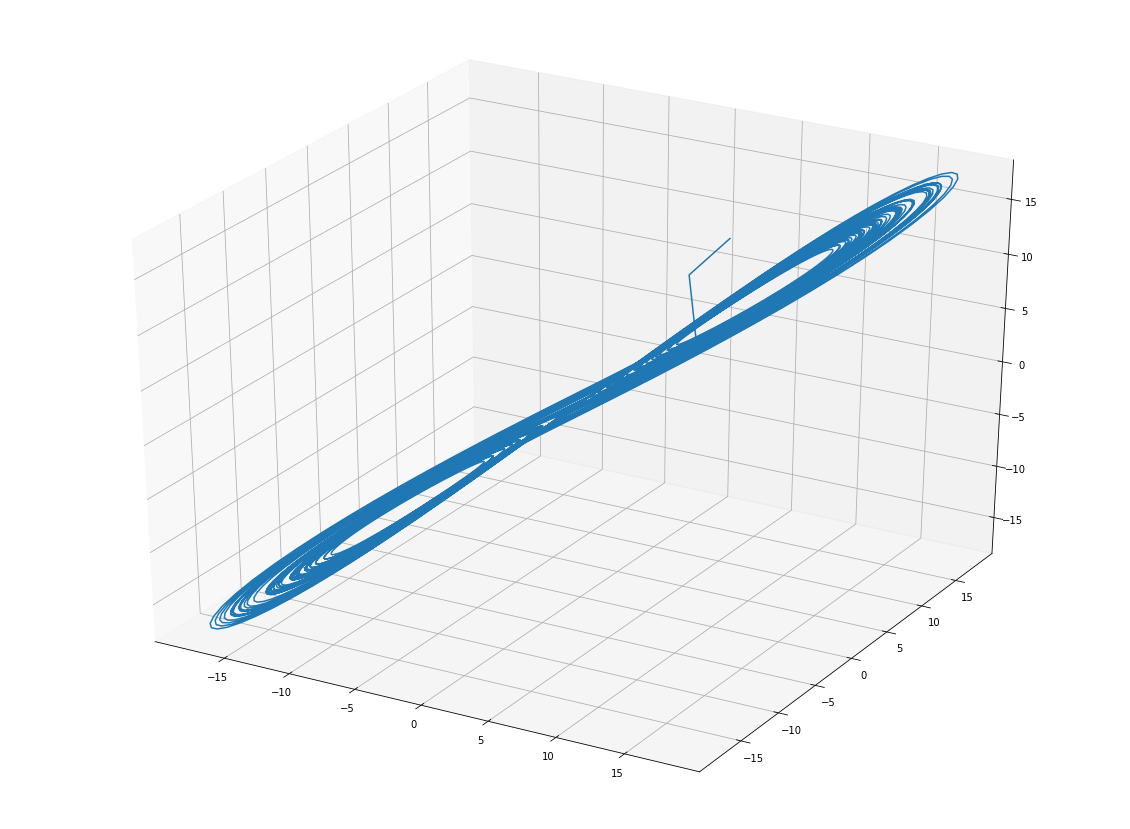

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,15))

#data = random_series
#data = sinus_series

data_lag0 = data[:-2].flatten()
data_lag1 = np.roll(data, -tau)[:-2].flatten()
data_lag2 = np.roll(data, -2 * tau)[:-2].flatten()

ax = fig.add_subplot(111, projection='3d')
ax.plot(data_lag0, data_lag1, data_lag2)

## MotionSense Dataset
---
Agora, iremos investigar a aplicação desta abordagem no conjunto de dados *MotionSense*. Para um conjunto de diferentes atividades físicas rotineiras - descer e subir escadas, caminhar, correr, sentar e levantar - uma série-temporal foi estruturada para uma pessoa.

Abaixo, vemos a representação de RP para cada atividade física monitorada da primeira pessoa do dataset:

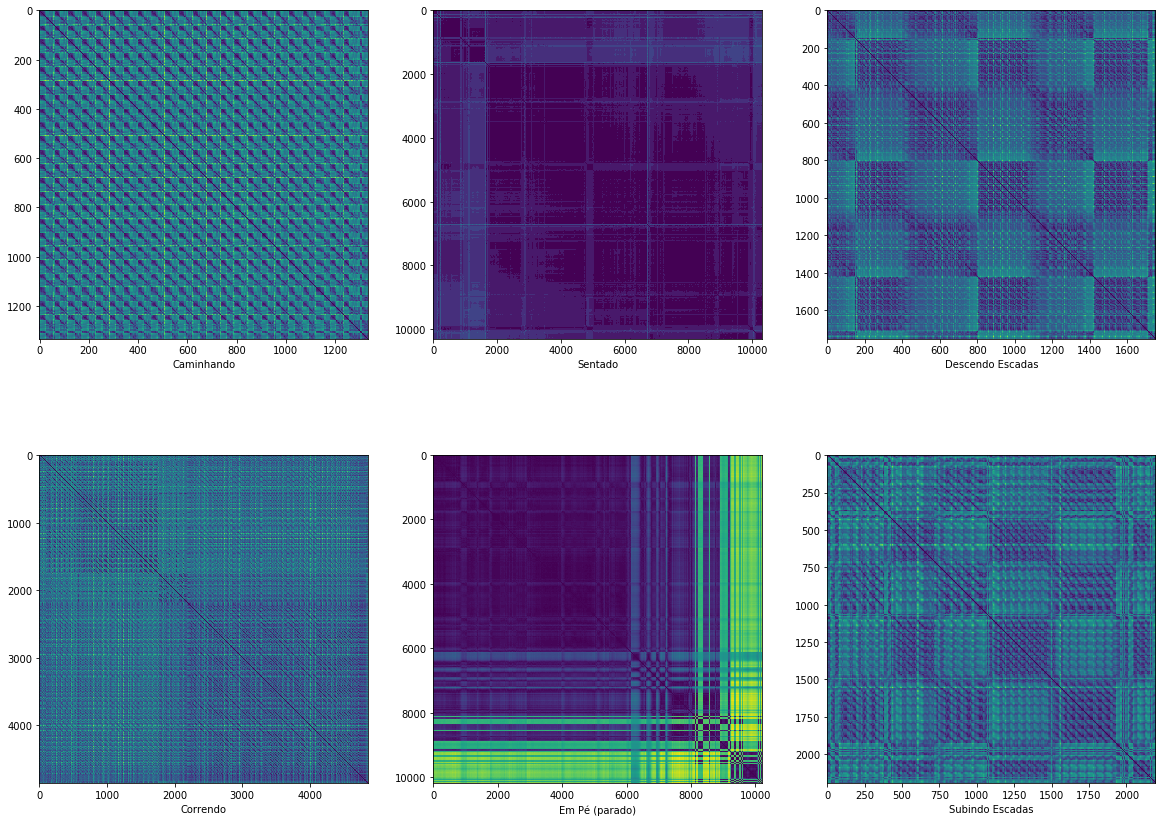

In [4]:
DATASET_PATH = './datasets/MotionSense/A_DeviceMotion_data/'

# Atributos coletados
cols = [
    "attitude.roll",
    "attitude.pitch",
    "attitude.yaw",
    "gravity.x",
    "gravity.y",
    "gravity.z",
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z",
    "userAcceleration.x", 
    "userAcceleration.y", 
    "userAcceleration.z"
]

# RPs
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(
    recurrence_plot(
        pd.read_csv(os.path.join(DATASET_PATH, "wlk_15/sub_1.csv"))[cols].values,
        steps=1000
    )
)
ax.set_xlabel('Caminhando')

ax = fig.add_subplot(2, 3, 2)
ax.imshow(
    recurrence_plot(
        pd.read_csv(os.path.join(DATASET_PATH, "sit_5/sub_1.csv"))[cols].values,
        steps=1000
    )
)
ax.set_xlabel('Sentado')

ax = fig.add_subplot(2, 3, 3)
ax.imshow(
    recurrence_plot(
        pd.read_csv(os.path.join(DATASET_PATH, "dws_1/sub_1.csv"))[cols].values,
        steps=1000
    )
)
ax.set_xlabel('Descendo Escadas')

ax = fig.add_subplot(2, 3, 4)
ax.imshow(
    recurrence_plot(
        pd.read_csv(os.path.join(DATASET_PATH, "jog_9/sub_1.csv"))[cols].values,
        steps=1000
    )
)
ax.set_xlabel('Correndo')

ax = fig.add_subplot(2, 3, 5)
ax.imshow(
    recurrence_plot(
        pd.read_csv(os.path.join(DATASET_PATH, "std_6/sub_1.csv"))[cols].values,
        steps=1000
    )
)
ax.set_xlabel('Em Pé (parado)')

ax = fig.add_subplot(2, 3, 6)
ax.imshow(
    recurrence_plot(
        pd.read_csv(os.path.join(DATASET_PATH, "ups_3/sub_1.csv"))[cols].values,
        steps=1000
    )
)
ax.set_xlabel('Subindo Escadas');

As imagens parecem bastante diferentes para atividades muito diferentes, enquanto caminhar / correr, descer / subir escadas e sentar / ficar em pé são semelhantes entre si.

Portanto, podemos esperar que modelos de classificação de imagens possam distinguir com eficiência entre os gráficos de recorrência de diferentes atividades. Por outro lado, como caminhar<>correr, subir<>descer escadas e sentar<>ficar em pé possuem padrões de recorrência que não diferem-se mutuamente, espera-se que eles não sejam tão fáceis de serem distinguidos. 

Para fins de aprendizado, representaremos cada uma dessas atividades como uma classe (rótulo) único. Além desta rotulação, temos que pré-processar os dados, ou seja, converter todas as séries-temporais em RP's e padronizarmos suas escalas.

In [14]:
# Convertendo as pastas em classe/rótulos
# - - -
# descer/subir escadas = 0, 
# caminhar/correr  = 1
# sentado/em pé = 2
class_translate = {"dws_1" : 0, "dws_2" : 0, "dws_11" : 0,  \
                   "ups_3" : 0, "ups_4" : 0, "ups_12" : 0, \
                   "wlk_7" : 1, "wlk_8" : 1, "wlk_15" : 1, \
                   "jog_9" : 1, "jog_16" : 1, \
                   "std_6" : 2, "std_14" : 2, \
                   "sit_5" : 2, "sit_13": 2}

#pre allocate arrays
x_train = np.zeros((384,32,32))
y_train = np.zeros(384)
c = 0
start = time.time()
for i in class_translate.keys():    
    print("Processando conjunto " + i)
    for j in range(1,25):
        dat = recurrence_plot(
                pd.read_csv(os.path.join(DATASET_PATH, i +"/" + "sub_"+ str(j) + ".csv"))[cols].values, 
                steps=100
            )
        dat = resize(dat, (32,32),mode='constant')
        x_train[c,:,:] = dat
        y_train[c] = class_translate[i]
        c = c + 1
end = time.time()
print('Tempo total (s):', end - start)

Processando conjunto dws_1
Processando conjunto dws_2
Processando conjunto dws_11
Processando conjunto ups_3
Processando conjunto ups_4
Processando conjunto ups_12
Processando conjunto wlk_7
Processando conjunto wlk_8
Processando conjunto wlk_15
Processando conjunto jog_9
Processando conjunto jog_16
Processando conjunto std_6
Processando conjunto std_14
Processando conjunto sit_5
Processando conjunto sit_13
Tempo total (s): 9460.048631429672


In [33]:
# Persistencia dos dados
np.save(os.path.join(DATASET_PATH,'../x_train'), x_train)
np.save(os.path.join(DATASET_PATH,'../y_train'), y_train)

## Modelo de Machine Learning baseado em CNN e RP
---
Em https://arxiv.org/pdf/1710.00886.pdf os autores propõem o uso de uma rede convolucional para a classificação de gráficos de recorrência.

In [5]:
model = Sequential()
 
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,32,32), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())

model.add(Dense(64, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 30, 30)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 15, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 15, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 13, 32)        8672      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)  

In [6]:
plot_model(model, to_file='model.png')

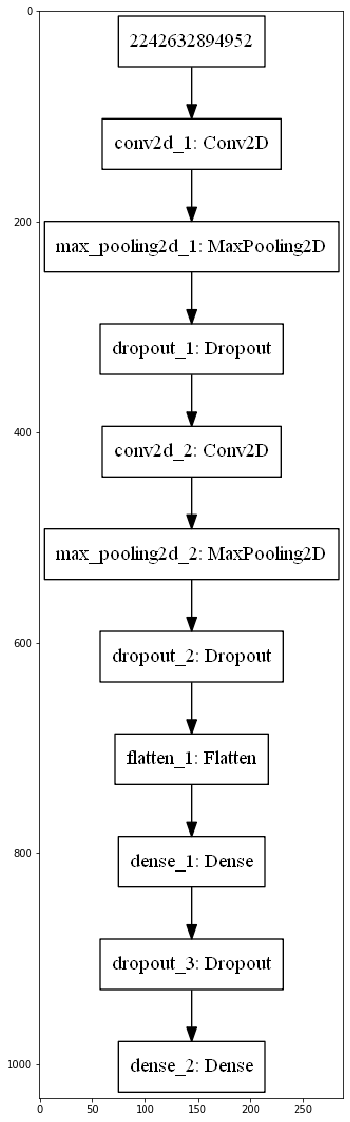

In [13]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,20))
plt.imshow( Image.open('model.png') )

Para treinar o modelo, iremos realizar a normalização das amostras, categorizar os rótulos (one-hot enconding) e separar 10% dos dados para testes de classificação.

In [32]:
# Carregando os dados persistidos
x_train = np.load(os.path.join(DATASET_PATH,'../x_train.npy') )
y_train = np.load(os.path.join(DATASET_PATH,'../y_train.npy') )

In [15]:
# Reformatar o conjunto X (profundidade)
X_train = x_train.reshape(x_train.shape[0], 1, 32,32)

# Normalizar os dados (forçar escala entre [0,1])
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)

# Converter rótulos para matriz de classes (one-hot-encoding)
Y_train = np_utils.to_categorical(y_train, 3)

# Separando conjunto de treino e testes (10%) 
X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

Treinando modelo com os dados...

In [16]:
model.fit(X_train, Y_train, epochs=200, batch_size=16,shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
345/345 [==============================] - 4s 12ms/step - loss: 1.0056 - acc: 0.4232
Epoch 2/200
345/345 [==============================] - 0s 347us/step - loss: 0.8354 - acc: 0.5681
Epoch 3/200
345/345 [==============================] - 0s 334us/step - loss: 0.7512 - acc: 0.6000
Epoch 4/200
345/345 [==============================] - 0s 307us/step - loss: 0.6936 - acc: 0.6754
Epoch 5/200
345/345 [==============================] - 0s 312us/step - loss: 0.6674 - acc: 0.6551
Epoch 6/200
345/345 [==============================] - 0s 312us/step - loss: 0.6639 - acc: 0.6551
Epoch 7/200
345/345 [==============================] - 0s 312us/step - loss: 0.6316 - acc: 0.7217
Epoch 8/200
345/345 [==============================] - 0s 315us/step - loss: 0.6706 - acc: 0.6638
Epoch 9/200
345/345 [==============================] - 0s 301us/step - loss: 0.6545 - acc: 0.6957
Epoch 10/200
345/345 [==============================] - 0s 318us/step -

Epoch 162/200
345/345 [==============================] - 0s 307us/step - loss: 0.0960 - acc: 0.9478
Epoch 163/200
345/345 [==============================] - 0s 304us/step - loss: 0.1060 - acc: 0.9391
Epoch 164/200
345/345 [==============================] - 0s 309us/step - loss: 0.1755 - acc: 0.9217
Epoch 165/200
345/345 [==============================] - 0s 307us/step - loss: 0.1193 - acc: 0.9420
Epoch 166/200
345/345 [==============================] - 0s 317us/step - loss: 0.1073 - acc: 0.9507
Epoch 167/200
345/345 [==============================] - 0s 315us/step - loss: 0.1068 - acc: 0.9478
Epoch 168/200
345/345 [==============================] - 0s 301us/step - loss: 0.1393 - acc: 0.9333
Epoch 169/200
345/345 [==============================] - 0s 304us/step - loss: 0.1017 - acc: 0.9507
Epoch 170/200
345/345 [==============================] - 0s 298us/step - loss: 0.1543 - acc: 0.9275
Epoch 171/200
345/345 [==============================] - 0s 307us/step - loss: 0.1881 - acc: 0.9246


Com o modelo testado, vamos avaliá-lo diante do conjunto de testes, confrontando a classe (atividade) prevista com a esperada.

In [17]:
predictions= model.predict(x_test)
rounded = [np.argmax(x) for x in predictions]
print(K.eval(metrics.categorical_accuracy(y_test, np_utils.to_categorical(rounded, 3))))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Referências:
    * https://www.kaggle.com/tigurius/recuplots-and-cnns-for-time-series-classification
    * https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification
    * http://node99.org/tutorials/ar/
    * https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

In [43]:
from sklearn import metrics as m
print(m.f1_score(y_test,  np_utils.to_categorical(rounded, 3), average='micro'))

0.9743589743589743


In [59]:
df_result = pd.concat([
        pd.DataFrame(y_test, columns=['y_0','y_1','y_2']), 
        pd.DataFrame(np_utils.to_categorical(rounded, 3), columns=['y_pred_0','y_pred__1','y_pred__2'])
    ], 
    axis=1)
df_result[['y_0','y_pred_0','y_1','y_pred__1','y_2','y_pred__2']]

,y_0,y_pred_0,y_1,y_pred__1,y_2,y_pred__2
0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,0.0,0.0
6,0.0,0.0,1.0,1.0,0.0,0.0
7,1.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,1.0,0.0,0.0
9,1.0,1.0,0.0,0.0,0.0,0.0
